# Figure 2

In [136]:
import numpy, pandas
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt

import MDAnalysis
import sbmlcore

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve, precision_score

from sklearn.base import BaseEstimator, TransformerMixin

## Figure 2a

In [5]:
DATASET = pandas.read_csv('data/ds-traintest-phen.csv')
def find_position(row):
    return int(row.MUTATION[1:-1])
DATASET['POSITION'] = DATASET.apply(find_position, axis=1)
DATASET

,MUTATION,CONSISTENT_PHENOTYPE,POSITION
0,A102V,S,102
1,A134D,S,134
2,A134P,R,134
3,A134S,S,134
4,A134V,R,134
...,...,...,...
659,Y95N,S,95
660,Y99C,S,99
661,Y99D,S,99
662,Y99F,S,99


Make a crosstab so we can pick out codons which tend to have mutations associated with resistance etc

In [111]:
df = pandas.crosstab(DATASET.POSITION, DATASET.CONSISTENT_PHENOTYPE)
df['TOTAL'] = df['S'] + df['R']
df['PROP_R'] = df['R']/df['TOTAL']
df

CONSISTENT_PHENOTYPE,R,S,TOTAL,PROP_R
POSITION,,,,
1,2,1,3,0.666667
2,0,1,1,0.000000
3,1,2,3,0.333333
4,4,1,5,0.800000
5,5,1,6,0.833333
...,...,...,...,...
181,1,1,2,0.500000
182,1,1,2,0.500000
183,1,2,3,0.333333


What is the distribution?

In [ ]:
df.PROP_R.value_counts().sort_index()

0.000000    38
0.166667     1
0.200000     3
0.250000    16
0.333333    25
0.400000     2
0.500000    21
0.600000     6
0.666667    19
0.750000     8
0.800000     6
0.833333     2
1.000000    37
Name: PROP_R, dtype: int64

First, let's pick up those codons where less than 20% of mutations are associated with resistance

In [109]:
df2 = df[df.PROP_R<=0.2]
'resid ' + ' '.join(str(i) for i in numpy.sort(df2.index.unique()))

'resid 2 11 15 20 25 33 37 39 40 45 50 53 56 60 61 64 73 74 80 83 84 87 91 95 98 99 100 102 107 111 112 113 121 126 141 144 148 157 167 169 178 185'

Then those where greater than 80% are associated with resistance

In [108]:
df2 = df[df.PROP_R>=0.8]
'resid ' + ' '.join(str(i) for i in numpy.sort(df2.index.unique()))

'resid 4 5 7 8 10 12 13 14 24 31 41 47 49 51 54 57 62 63 68 69 71 72 76 93 94 96 97 103 104 108 116 119 132 135 138 139 142 146 155 159 164 165 170 175 180'

..and finally those where between 40 and 60% of mutations are associated with resistance

In [112]:
df2 = df[(df.PROP_R>=0.4) & (df.PROP_R<=0.6)]
'resid ' + ' '.join(str(i) for i in numpy.sort(df2.index.unique()))

'resid 17 30 32 38 42 44 55 65 70 81 82 90 92 101 105 110 115 118 120 125 133 134 147 154 160 166 181 182 184'

Create a PDB file with the proportion of resistance stored in the `BETA` column

In [118]:
u = MDAnalysis.Universe('data/reference/3PL1-PZA.pdb')

positions = df[(df.PROP_R==0)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 0

positions = df[(df.PROP_R>0) & (df.PROP_R<0.2)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 16.667

positions = df[(df.PROP_R==0.2)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 20

positions = df[(df.PROP_R==0.25)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 25

positions = df[(df.PROP_R>0.25) & (df.PROP_R<0.4)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 33.3333

positions = df[(df.PROP_R==0.4)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 40

positions = df[(df.PROP_R==0.5)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 50

positions = df[(df.PROP_R==0.6)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 60

positions = df[(df.PROP_R>0.6) & (df.PROP_R<0.7)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 66.66667

positions = df[(df.PROP_R==0.75)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 75

positions = df[(df.PROP_R==0.8)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 80

positions = df[(df.PROP_R>0.8) & (df.PROP_R<0.9)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 83.3333

positions = df[(df.PROP_R==1)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 100

all = u.select_atoms('all')
all.write('data/reference/3PL1-PZA-beta.pdb')

/Users/fowler/Library/Python/3.10/lib/python/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/fowler/Library/Python/3.10/lib/python/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


## Figure 2b

In [122]:

df = pandas.read_csv('data/ds-traintest-phen-features.csv')
dataset = sbmlcore.FeatureDataset(df, species='M. tuberculosis', gene='pncA')
dataset.df


,segid,mutation,phenotype,d_volume,d_hydropathy_KD,d_Pi,d_MW,d_rogov,phi,psi,...,depth,deep_ddG,rasp_wt_nlf,rasp_mt_nlf,rasp_score_ml_fermi,rasp_score_ml,snap2_score,snap2_accuracy,dist_FE2,dist_PZA
0,A,M1L,R,3.8,1.9,0.24,-18.0,-0.389,0.00,-35.20,...,2.103049,-0.770,3.785957,2.433114,0.223921,-0.107405,20,63,29.948318,27.641663
1,A,M1T,R,-46.8,-2.6,-0.14,-30.1,-0.548,0.00,-35.20,...,2.103049,-1.096,3.785957,2.896883,0.281366,0.655765,52,75,29.948318,27.641663
2,A,M1V,S,-22.9,2.3,0.22,-32.1,-0.514,0.00,-35.20,...,2.103049,-0.908,3.785957,2.623741,0.258386,0.364061,4,53,29.948318,27.641663
3,A,R2Q,S,-29.6,1.0,-5.11,-28.0,0.375,-117.94,133.99,...,2.372958,-1.144,3.035567,3.338515,0.331465,1.246086,-26,61,27.459823,24.722696
4,A,A3E,R,49.8,-5.3,-2.78,58.0,-0.033,-126.53,153.85,...,5.503930,-5.340,2.483982,2.712832,0.554393,3.546088,56,75,24.149025,21.557456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,A,S185G,S,-28.9,0.4,0.29,-30.0,0.120,-73.76,0.00,...,1.798143,-0.900,2.844502,2.560213,0.273806,0.561510,69,80,27.305858,22.750537
660,A,S185I,S,77.7,5.3,0.34,26.1,-0.026,-73.76,0.00,...,1.798143,0.128,2.844502,2.854018,0.215031,-0.237151,62,80,27.305858,22.750537
661,A,S185N,S,25.1,-2.7,-0.27,27.0,0.271,-73.76,0.00,...,1.798143,-1.120,2.844502,3.127102,0.229262,-0.031213,53,75,27.305858,22.750537
662,A,S185R,S,84.4,-3.7,5.08,69.1,0.127,-73.76,0.00,...,1.798143,-0.811,2.844502,3.035567,0.274627,0.571823,67,80,27.305858,22.750537


In [128]:
def return_colour(row):
    if row.phenotype == 'R':
        return '#e41a1c'
    elif row.phenotype == 'S':
        return '#377eb8'
    else:
        return(None)

dataset.df['phenotype_colour'] = dataset.df.apply(return_colour, axis=1)


array([[<AxesSubplot:xlabel='d_volume', ylabel='d_volume'>,
        <AxesSubplot:xlabel='d_hydropathy_KD', ylabel='d_volume'>,
        <AxesSubplot:xlabel='d_Pi', ylabel='d_volume'>,
        <AxesSubplot:xlabel='d_MW', ylabel='d_volume'>,
        <AxesSubplot:xlabel='d_rogov', ylabel='d_volume'>,
        <AxesSubplot:xlabel='phi', ylabel='d_volume'>,
        <AxesSubplot:xlabel='psi', ylabel='d_volume'>,
        <AxesSubplot:xlabel='residue_sasa', ylabel='d_volume'>,
        <AxesSubplot:xlabel='n_hbond_acceptors', ylabel='d_volume'>,
        <AxesSubplot:xlabel='n_hbond_donors', ylabel='d_volume'>,
        <AxesSubplot:xlabel='secondary_structure_codes', ylabel='d_volume'>,
        <AxesSubplot:xlabel='temp_factor', ylabel='d_volume'>,
        <AxesSubplot:xlabel='depth', ylabel='d_volume'>,
        <AxesSubplot:xlabel='deep_ddG', ylabel='d_volume'>,
        <AxesSubplot:xlabel='rasp_wt_nlf', ylabel='d_volume'>,
        <AxesSubplot:xlabel='rasp_mt_nlf', ylabel='d_volume'>,
        <A

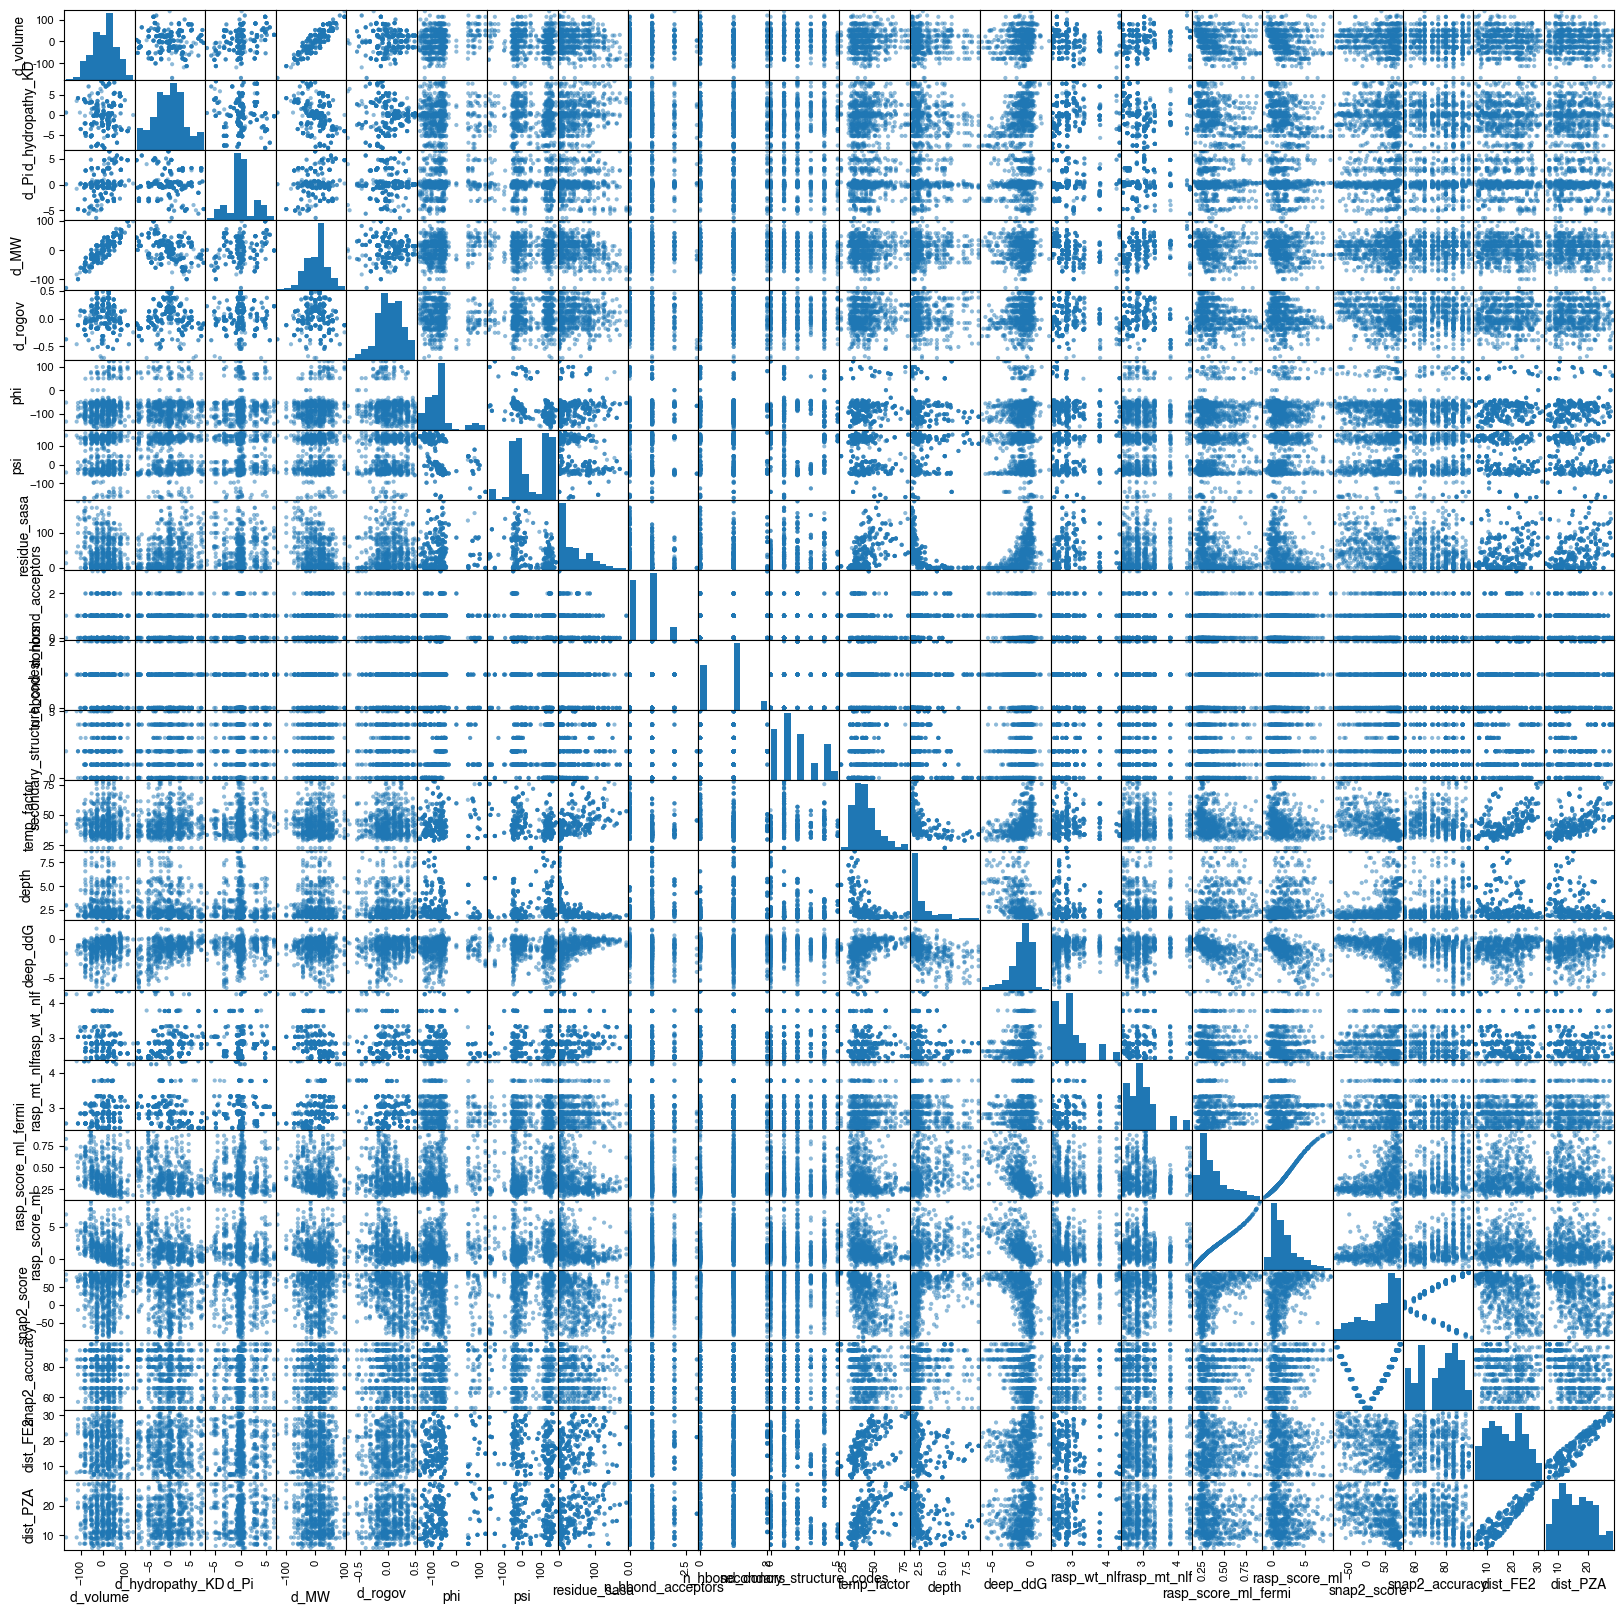

In [139]:
scatter_matrix(dataset.df, figsize=(20,20))

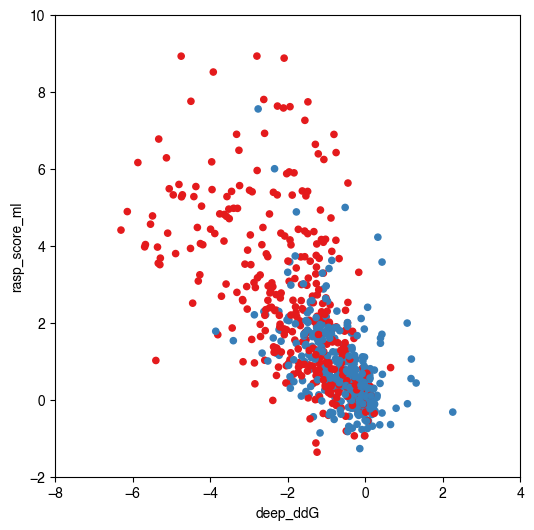

In [134]:
axes = dataset.df.plot.scatter(x='deep_ddG', y='rasp_score_ml', c='phenotype_colour', figsize=(6,6))
axes.set_ylim([-2,10])
axes.set_xlim([-8,4])
axes.get_figure().savefig('foo.pdf')